<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/analysis/08_AESurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchtuples
! pip install pycox
! pip install hiddenlayer

     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 


In [2]:
import numpy as np
import feather
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear
import torchtuples as tt

from pycox.models import LogisticHazard
from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

import os

In [3]:
# random
np.random.seed(1234)
_ = torch.manual_seed(1234)

In [4]:
class NetAESurv(nn.Module):
    def __init__(self, in_features, encoded_features, out_features):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_features),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
        )

        # Full connection
        self.survnet = nn.Sequential(
            nn.Linear(encoded_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )

    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        phi = self.survnet(encoded)
        return phi, decoded

    def predict(self, input):
        encoded = self.encoder(input)
        return self.survnet(encoded)


In [5]:
class LossAELogHaz(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        assert (alpha >= 0) and (alpha <= 1), "Need `alpha` in [0, 1]."
        self.alpha = alpha
        self.loss_surv = NLLLogistiHazardLoss()
        self.loss_ae = nn.MSELoss()

    def forward(self, phi, decoded, target_loghaz, target_ae):
        idx_durations, events = target_loghaz
        loss_surv = self.loss_surv(phi, idx_durations, events)
        loss_ae = self.loss_ae(decoded, target_ae)
        return self.alpha * loss_surv + (1 - self.alpha) * loss_ae


In [6]:
def load_data(filepath):
    df = feather.read_dataframe(source=filepath)
    df_train = df.loc[df.oc == "OC521"].drop(columns=["barcode", "oc"], axis=1)
    df_val = df.loc[df.oc == "OC44"].drop(columns=["barcode", "oc"], axis=1)
    df_test1 = df.loc[df.oc == "OC79"].drop(columns=["barcode", "oc"], axis=1)
    df_test2 = df.loc[df.oc == "OC172"].drop(columns=["barcode", "oc"], axis=1)
    return df_train, df_val, df_test1, df_test2


def get_target(df):
    return (df["duration"].values, df["event"].values)


def transform_features(df_train, df_val, df_test1, df_test2):
    columns = df_train.columns
    columns = columns[: len(columns) - 2]
    standardize = [([col], StandardScaler()) for col in columns]

    x_mapper = DataFrameMapper(standardize)

    x_train = x_mapper.fit_transform(df_train).astype("float32")
    x_val = x_mapper.transform(df_val).astype("float32")
    x_test1 = x_mapper.transform(df_test1).astype("float32")
    x_test2 = x_mapper.transform(df_test2).astype("float32")

    return x_train, x_val, x_test1, x_test2


def transform_labels(df_train, df_val, nd=10):
    num_durations = nd
    labtrans = LogisticHazard.label_transform(num_durations)
    y_train_surv = labtrans.fit_transform(*get_target(df_train))
    y_val_surv = labtrans.transform(*get_target(df_val))

    return y_train_surv, y_val_surv, labtrans


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
filepath="/content/drive/MyDrive/colab-data/total416.os.se.norm.feather"

In [9]:
# load data
df_train, df_val, df_test1, df_test2 = load_data(filepath)
# transform features
x_train, x_val, x_test1, x_test2 = transform_features(df_train, df_val, df_test1, df_test2)
# transform labels
y_train_surv, y_val_surv, labtrans = transform_labels(df_train, df_val)

In [10]:
# make train and validation datasets with tuplefy
train = tt.tuplefy(x_train, (y_train_surv, x_train))
val = tt.tuplefy(x_val, (y_val_surv, x_val))

In [11]:
durations_test1, events_test1 = get_target(df_test1)
durations_test2, events_test2 = get_target(df_test2)

In [12]:
# set arch
in_features = x_train.shape[1]
encoded_features = 64
out_features = labtrans.out_features
netaesurv = NetAESurv(in_features, encoded_features, out_features)

In [13]:
netaesurv

NetAESurv(
  (encoder): Sequential(
    (0): Linear(in_features=6636, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=6636, bias=True)
  )
  (survnet): Sequ

In [14]:
from torchsummary import summary
summary(model=netaesurv, input_size=(1, in_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]      13,592,576
              ReLU-2              [-1, 1, 2048]               0
            Linear-3              [-1, 1, 1024]       2,098,176
              ReLU-4              [-1, 1, 1024]               0
            Linear-5               [-1, 1, 512]         524,800
              ReLU-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
              ReLU-8               [-1, 1, 256]               0
            Linear-9               [-1, 1, 128]          32,896
             ReLU-10               [-1, 1, 128]               0
           Linear-11                [-1, 1, 64]           8,256
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

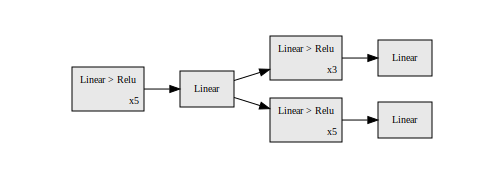

In [15]:
import hiddenlayer as hl
hl.build_graph(netaesurv, torch.zeros([1, in_features]))

In [16]:
# loss
loss = LossAELogHaz(0.6)

In [17]:
loss

LossAELogHaz(
  (loss_surv): NLLLogistiHazardLoss()
  (loss_ae): MSELoss()
)

In [18]:
# model
model = LogisticHazard(net=netaesurv, optimizer=tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss=loss)

In [19]:
# metrics
metrics = dict(loss_surv=LossAELogHaz(1), loss_ae=LossAELogHaz(0))

# callbacks
callbacks = [tt.cb.EarlyStopping()]

# cycling
batch_size = 5
epochs = 100

# trainning model
log = model.fit(
    *train, batch_size=batch_size, epochs=epochs,  verbose=True, val_data=val, metrics=metrics
)

0:	[19s / 19s],		train_loss: 78.5236,	train_loss_surv: 1.6166,	train_loss_ae: 193.8842,	val_loss: 1.2073,	val_loss_surv: 1.2210,	val_loss_ae: 1.1867
1:	[18s / 37s],		train_loss: 3.1899,	train_loss_surv: 1.0980,	train_loss_ae: 6.3276,	val_loss: 1.4693,	val_loss_surv: 1.2289,	val_loss_ae: 1.8298
2:	[18s / 56s],		train_loss: 1608.3686,	train_loss_surv: 1.0817,	train_loss_ae: 4019.2991,	val_loss: 42.6363,	val_loss_surv: 1.2184,	val_loss_ae: 104.7632
3:	[18s / 1m:14s],		train_loss: 71.2216,	train_loss_surv: 1.0962,	train_loss_ae: 176.4098,	val_loss: 2949.0327,	val_loss_surv: 1.3234,	val_loss_ae: 7370.5967
4:	[18s / 1m:33s],		train_loss: 482.0427,	train_loss_surv: 1.0524,	train_loss_ae: 1203.5281,	val_loss: 1.1082,	val_loss_surv: 1.2688,	val_loss_ae: 0.8672
5:	[18s / 1m:51s],		train_loss: 1.0319,	train_loss_surv: 1.0463,	train_loss_ae: 1.0103,	val_loss: 1.1066,	val_loss_surv: 1.2791,	val_loss_ae: 0.8478
6:	[18s / 2m:10s],		train_loss: 1.0281,	train_loss_surv: 1.0458,	train_loss_ae: 1.0016,	v

In [21]:
res = model.log.to_pandas()

In [22]:
res.tail(20)

,train_loss,train_loss_surv,train_loss_ae,val_loss,val_loss_surv,val_loss_ae
80,1.015072,1.023920,1.001800,1.090456,1.254525,0.844352
81,1.022124,1.038106,0.998152,1.081399,1.239399,0.844399
82,1.021126,1.031343,1.005800,1.088705,1.251523,0.844478
83,1.020624,1.033220,1.001729,1.083593,1.243040,0.844423
84,1.024249,1.037351,1.004596,1.082906,1.241915,0.844392
85,1.017702,1.030050,0.999180,1.089134,1.252246,0.844465
86,1.024551,1.036342,1.006864,1.091206,1.255717,0.844438
87,1.019772,1.034995,0.996938,1.075321,1.229271,0.844397
88,1.023215,1.037814,1.001317,1.087453,1.249407,0.844522
89,1.024054,1.039507,1.000874,1.090004,1.253749,0.844387


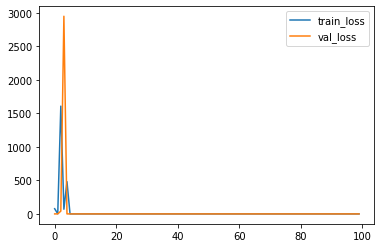

In [23]:
_ = res[['train_loss', 'val_loss']].plot()

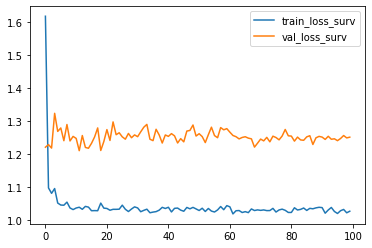

In [24]:
_ = res[['train_loss_surv', 'val_loss_surv']].plot()

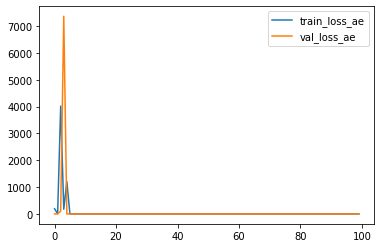

In [25]:
_ = res[['train_loss_ae', 'val_loss_ae']].plot()

In [26]:
surv1 = model.interpolate(10).predict_surv_df(x_test1)
surv2 = model.interpolate(10).predict_surv_df(x_test2)

In [27]:
surv1.iloc[:, :5]

,0,1,2,3,4
0.000000,0.996647,0.996647,0.996647,0.996647,0.996647
1.944444,0.979766,0.979766,0.979766,0.979766,0.979766
3.888889,0.962886,0.962886,0.962886,0.962886,0.962886
5.833333,0.946005,0.946005,0.946005,0.946005,0.946005
7.777778,0.929125,0.929125,0.929125,0.929125,0.929125
...,...,...,...,...,...
167.222222,0.110303,0.110303,0.110303,0.110303,0.110303
169.166667,0.110250,0.110250,0.110250,0.110250,0.110250
171.111111,0.110197,0.110197,0.110197,0.110197,0.110197
173.055556,0.110144,0.110144,0.110144,0.110144,0.110144


In [28]:
surv2.iloc[:, :5]

,0,1,2,3,4
0.000000,0.996647,0.996647,0.996647,0.996647,0.996647
1.944444,0.979766,0.979766,0.979766,0.979766,0.979766
3.888889,0.962886,0.962886,0.962886,0.962886,0.962886
5.833333,0.946005,0.946005,0.946005,0.946005,0.946005
7.777778,0.929125,0.929125,0.929125,0.929125,0.929125
...,...,...,...,...,...
167.222222,0.110303,0.110303,0.110303,0.110303,0.110303
169.166667,0.110250,0.110250,0.110250,0.110250,0.110250
171.111111,0.110197,0.110197,0.110197,0.110197,0.110197
173.055556,0.110144,0.110144,0.110144,0.110144,0.110144


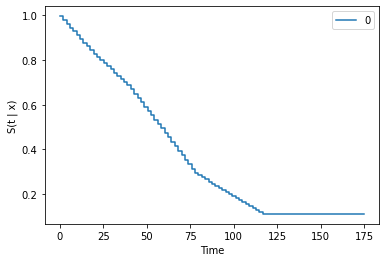

In [29]:
surv1.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

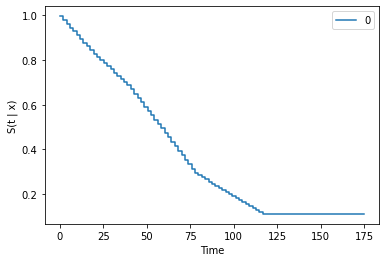

In [30]:
surv2.iloc[:, :1].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [31]:
model.predict(x_test1[:2])

array([[-5.694374  , -1.5900757 , -1.5913259 , -0.93442655, -0.36597943,
        -0.79988575, -0.20613745, -6.9760876 , -6.335179  , -5.33589   ],
       [-5.694374  , -1.5900757 , -1.5913259 , -0.93442655, -0.36597943,
        -0.79988575, -0.20613745, -6.9760876 , -6.335179  , -5.33589   ]],
      dtype=float32)

In [32]:
model.predict_net(x_test1[:2])

(array([[-5.694374  , -1.5900757 , -1.5913259 , -0.93442655, -0.36597943,
         -0.79988575, -0.20613745, -6.9760876 , -6.335179  , -5.33589   ],
        [-5.694374  , -1.5900757 , -1.5913259 , -0.93442655, -0.36597943,
         -0.79988575, -0.20613745, -6.9760876 , -6.335179  , -5.33589   ]],
       dtype=float32),
 array([[-0.00707362,  0.00024423, -0.00950024, ..., -0.00254421,
          0.01054826, -0.0072751 ],
        [-0.00707362,  0.00024423, -0.00950024, ..., -0.00254421,
          0.01054826, -0.0072751 ]], dtype=float32))

In [33]:
evs1 = EvalSurv(surv1, durations_test1, events_test1, censor_surv='km')
evs2 = EvalSurv(surv2, durations_test2, events_test2, censor_surv='km')

In [34]:
evs1.concordance_td()

0.5

In [35]:
evs2.concordance_td()

0.508686210640608

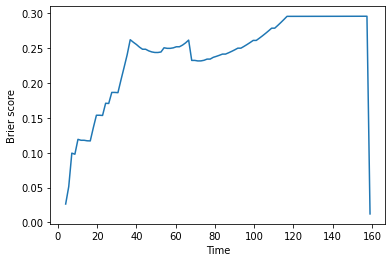

In [36]:
time_grid = np.linspace(durations_test1.min(), durations_test1.max(), 100)
evs1.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

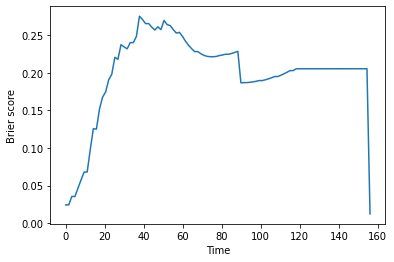

In [37]:
time_grid = np.linspace(durations_test2.min(), durations_test2.max(), 100)
evs2.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

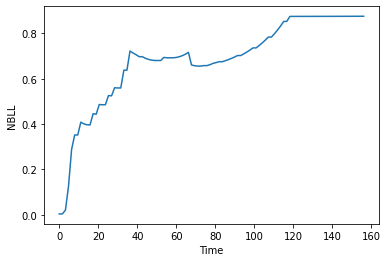

In [38]:
evs1.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

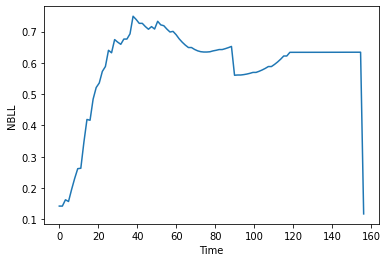

In [39]:
evs2.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [40]:
evs1.integrated_brier_score(time_grid)

0.23473019380688756

In [41]:
evs1.integrated_nbll(time_grid)

0.6821513526376256

In [42]:
evs2.integrated_brier_score(time_grid)

0.20064117904397497

In [43]:
evs2.integrated_nbll(time_grid)

0.5945015352255995